In [1]:
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00


In [2]:
!pip install iterative-stratification

Make sure the following folders are correct for you.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd 'drive/Othercomputers/My Computer (1)/EmotionTeller-github'

/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github


We import the metadata and remove the rows of missing files.

In [43]:
import pandas as pd
import ast
import os
from pathlib import Path

data_root       = Path('Data') # Folder where all data sources are stored
dataset_path    = data_root/'ImageData' # List of folders containing images in .jpg format
data_meta       = ['emotic-relabelled.csv',
                'hgel-relabelled.csv'] # List of metadata corresponding to previous list of folders in .csv format. In our case we relabelled some of the data, so this is different from original metadata.
meta_root       = Path('Metadata')
yolo_dir        = Path('YOLO_training')
os.makedirs(yolo_dir, exist_ok=True)

In [18]:
df = pd.read_csv(meta_root/'train_meta.csv')
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(dataset_path/x.file_name),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


In [19]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


We do an stratified train-val split.

In [20]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

In [21]:
mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx = np.arange(len(df))

(train_idx, test_idx), = mss.split(idx, y)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df  = df.iloc[test_idx].reset_index(drop=True)

The emotions to be detected by the model.

In [22]:
emo_dic = {'Neutral':0,'Happy':1,'Surprise':2,'Sad':3,'Angry':4,'Fear':5,'Disgust':6}

The following two cells, create new folders with labels and pictures for our training and validation sets according the structure required by `YOLO`.

In [24]:
def xywh2xcycwh(x,y,w,h):
  return [x + w/2, y + h/2, w/2, h/2]

def label(item):
  objs = item['objects']
  text_label = ''
  for ind, emotion in enumerate(objs['categories']):
    x,y,w,h = np.array(objs['bbox'][ind])/100 # Unpack the list into four variables
    xc,yc,wc,hc = xywh2xcycwh(x,y,w,h) # Pass the four variables to the function
    text_label += f'{emo_dic[emotion]} {xc} {yc} {wc} {hc}\n'
  return text_label

In [33]:
import shutil
from tqdm import tqdm

# Create directories for train and validation images and labels
os.makedirs(yolo_dir/'images'/'train', exist_ok=True)
os.makedirs(yolo_dir/'labels'/'train', exist_ok=True)
os.makedirs(yolo_dir/'images'/'val', exist_ok=True)
os.makedirs(yolo_dir/'labels'/'val', exist_ok=True)

#for index, row in train_df.iterrows():

# Generate labels and copy images for the training set
for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Copying train files"):
    image_name = row['file_name']
    label_content = label(row)
    with open(yolo_dir/'labels'/'train'/image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(dataset_path/image_name, yolo_dir/'images'/'train'/image_name)

#for index, row in test_df.iterrows():
# Generate labels and copy images for the validation set
for index, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Copying validation files"):
    image_name = row['file_name']
    label_content = label(row) # FIX THIS
    with open(yolo_dir/'labels'/'val'/image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(dataset_path/image_name, yolo_dir/'images'/'val'/image_name)

print("\n Generated label files and copied images for train and validation sets.")

Copying validation files: 100%|██████████| 36/36 [00:19<00:00,  1.83it/s]

Generated label files and copied images for train and validation sets.


Make sure `data.yaml` is in the `ds_folder`, this contains the structure for the train/val pictures and labels.

In [34]:
model = YOLO('yolo11n.pt')

results = model.train(data = yolo_dir/'data.yaml', project= yolo_dir/"runs", imgsz=1024, epochs = 300,device=0, rect= True)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

We use our model to predict on train and validation sets. Make sure you select the correct weights for the latest run.

In [35]:
fine_tuned = YOLO('YOLO_training/runs/train/weights/best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: yolo_dir/'images'/'val'/x.file_name,axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: yolo_dir/'images'/'train'/x.file_name,axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))


0: 1024x1024 1 Sad, 1.5ms
1: 1024x1024 1 Disgust, 1.5ms
2: 1024x1024 (no detections), 1.5ms
3: 1024x1024 1 Happy, 1 Disgust, 1.5ms
4: 1024x1024 (no detections), 1.5ms
5: 1024x1024 (no detections), 1.5ms
6: 1024x1024 3 Neutrals, 1 Happy, 1.5ms
7: 1024x1024 4 Neutrals, 1.5ms
8: 1024x1024 1 Neutral, 1.5ms
9: 1024x1024 1 Disgust, 1.5ms
10: 1024x1024 1 Neutral, 1.5ms
11: 1024x1024 1 Disgust, 1.5ms
12: 1024x1024 1 Neutral, 2 Happys, 1.5ms
13: 1024x1024 (no detections), 1.5ms
14: 1024x1024 (no detections), 1.5ms
15: 1024x1024 1 Angry, 1 Disgust, 1.5ms
16: 1024x1024 (no detections), 1.5ms
17: 1024x1024 1 Sad, 1.5ms
18: 1024x1024 (no detections), 1.5ms
19: 1024x1024 1 Neutral, 1 Happy, 1 Angry, 1.5ms
20: 1024x1024 (no detections), 1.5ms
21: 1024x1024 (no detections), 1.5ms
22: 1024x1024 (no detections), 1.5ms
23: 1024x1024 (no detections), 1.5ms
24: 1024x1024 (no detections), 1.5ms
25: 1024x1024 1 Happy, 1.5ms
26: 1024x1024 (no detections), 1.5ms
27: 1024x1024 (no detections), 1.5ms
28: 1024x1

To see how this compares to original labelling, set `pic_id` to any index in the training dataset and run the cell below it.

In [36]:
pic_id=55

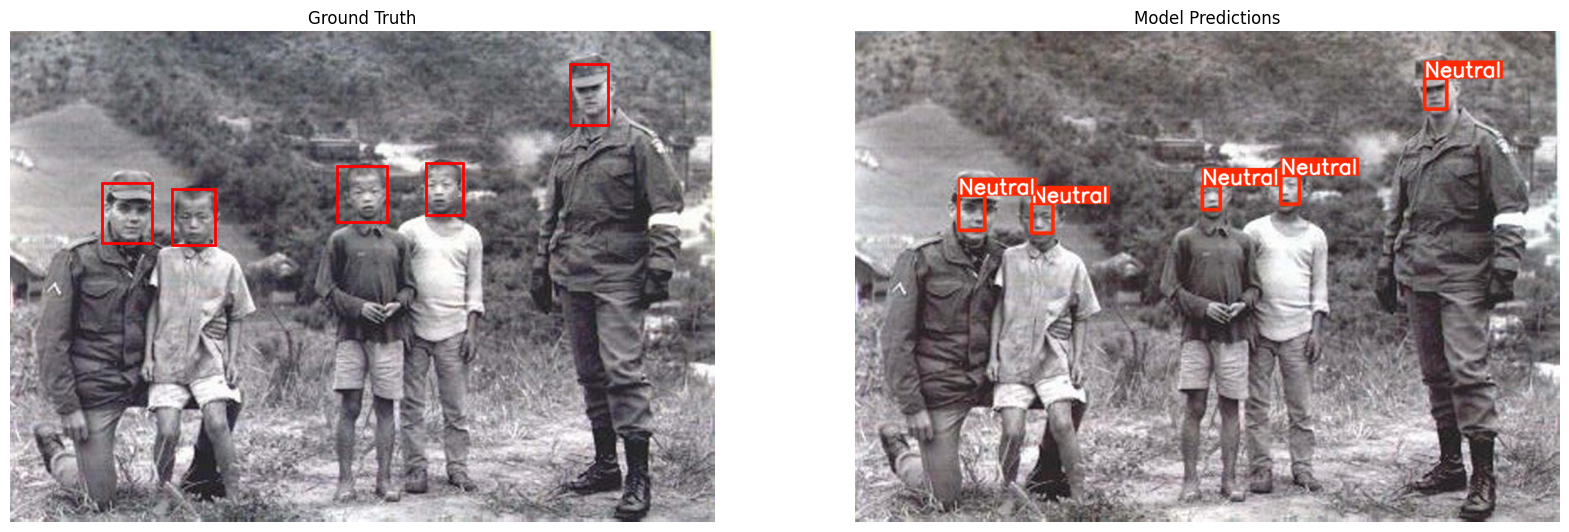

In [37]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test = train_df.iloc[pic_id]

width = test['original_width']
height = test['original_height']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the original image with ground truth bounding boxes on the left subplot
axes[0].imshow(Image.open(os.path.join(yolo_dir,'images','train',test['file_name'])))
axes[0].set_title('Ground Truth')
axes[0].axis("off")

for bbox in test['objects']['bbox']:
  bbox = np.array(bbox)/100
  x, y, w, h = bbox*[width,height,width,height]

  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  axes[0].add_patch(rect)

#Display the image with model predictions on the right subplot
axes[1].imshow(train_preds[pic_id].plot(conf = False, line_width = int(width*0.003))) # YOLO's plot method returns an image
axes[1].set_title('Model Predictions')
axes[1].axis("off")

plt.show()

### Training with KFolds

Below we will create stratified KFolds and split our images to train following this [guide](https://docs.ultralytics.com/guides/kfold-cross-validation/#k-fold-dataset-split) and this [package](https://github.com/trent-b/iterative-stratification).

In [39]:
df = pd.read_csv(meta_root/'train_meta.csv')
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(data_folders/x.file_name),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


Below we create a dataframe whose indices are the pictures in our train set and has a column for each fold in our n-Fold Cross-Validation. The entry in each column determins if that picture belongs to the train or validation set in that corresponding fold.

In [41]:
index = list(df['file_name'])

mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

ksplit = 5

msk = MultilabelStratifiedKFold(n_splits=ksplit, shuffle=True, random_state=42)
idx = np.arange(len(df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

kfolds = list(msk.split(idx, y))

#For every image, we write if they belong to "train" or "val" in each respective fold
for i, (train_idx, val_idx) in enumerate(kfolds, start=1):
    col = f"split_{i}"
    col_pos = folds_df.columns.get_loc(col)
    folds_df.iloc[train_idx,col_pos] = "train"
    folds_df.iloc[val_idx,col_pos] = "val"



In [44]:
import datetime
import yaml

yaml_file = yolo_dir/"data.yaml"  # your data YAML with data directories and names dictionary

with open(yaml_file, encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]

# List with image file paths
images = list(df["file_name"].apply(lambda x: dataset_path/x))

# Create the necessary directories and dataset YAML files
save_path = yolo_dir / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val"
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

We now copy each image to their respective n-Fold Cross-Validation folder.

In [45]:
for image in tqdm(images, total=len(images), desc="Copying files"):
    for split, k_split in folds_df.loc[image.name].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        row = df.loc[df["file_name"] == image.name].iloc[0]
        label_content = label(row)
        with open(lbl_to_path/image.name.replace('.jpg', '.txt'), 'w') as f:
            f.write(label_content)

Copying files: 100%|██████████| 178/178 [00:11<00:00, 14.87it/s]


We now evaluate how the base yolo model performs in n-fold cross validation.

In [46]:
results = {}

batch = 32
project = save_path/"runs"
epochs = 300
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True
    )  # include any additional train arguments

Streaming output truncated to the last 5000 lines.
                   all         35        212      0.317      0.192       0.14     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/300      12.4G      1.594      1.577       1.13         23        768: 100% ━━━━━━━━━━━━ 5/5 5.7it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 5.6it/s 0.2s
                   all         35        212      0.396       0.12      0.095     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/300      12.4G      1.662      1.569      1.148         23        768: 100% ━━━━━━━━━━━━ 5/5 5.5it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 6.3it/s 0.2s
                   all         35        212       0.39      0.146     0.0796     0.0246

      Epoch    GPU_mem   box_loss   cls_loss 

A summary of our results for the n-Fold Cross-Validation.

In [54]:
ksplit = 5

results = []

for k in range(ksplit):
  results.append(pd.read_csv(project/f'fold_{k+1}'/'results.csv').iloc[-1])
results_df = pd.DataFrame(results,index=[f'fold_{k+1}' for k in range(ksplit)])
results_df.describe()


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,200.40000,319.945200,0.911050,0.609872,0.878924,0.229638,0.146876,0.104648,0.032592,2.65479,2.657628,1.749272,0.000311,0.000311,0.000311
std,32.23042,41.947843,0.118566,0.072997,0.034061,0.131869,0.039314,0.014986,0.006212,0.13274,0.231750,0.135597,0.000097,0.000097,0.000097
min,160.00000,254.226000,0.790030,0.538660,0.847350,0.101080,0.090790,0.082520,0.024170,2.42875,2.439730,1.542800,0.000231,0.000231,0.000231
25%,171.00000,302.373000,0.838910,0.560940,0.850620,0.136910,0.132170,0.097730,0.029580,2.64463,2.479340,1.709230,0.000237,0.000237,0.000237
50%,219.00000,340.132000,0.861840,0.573080,0.875660,0.229970,0.142820,0.107200,0.033830,2.71738,2.575890,1.769650,0.000255,0.000255,0.000255
75%,225.00000,349.039000,0.984340,0.678840,0.890020,0.240060,0.183110,0.116600,0.034460,2.72946,2.810920,1.821550,0.000399,0.000399,0.000399
max,227.00000,353.956000,1.080130,0.697840,0.930970,0.440170,0.185490,0.119190,0.040920,2.75373,2.982260,1.903130,0.000432,0.000432,0.000432


The cell below is just to test

In [ ]:
fine_tuned = YOLO(project/f'fold_{k+1}'/'weights'/'best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: os.path.join(yolo_dir,'images','val',x.file_name),axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: os.path.join(yolo_dir,'images','train',x.file_name),axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import pandas as pd
import os
import ast
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import datetime
import yaml


# Load and process metadata to define df
meta_root = 'Metadata'
data_root = 'Data'
data_folders = 'ImageData'

df = pd.read_csv(os.path.join(meta_root,'train_meta.csv'))
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(os.path.join(data_root,data_folders,x.file_name)),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

# Set the index of df to file_name to align with folds_df
df.set_index('file_name', inplace=True)

# Define folds_df and save_path
index = list(df.index) # Use the index of df

mlb = MultiLabelBinarizer()

y = mlb.fit_transform(df['emotions'])

ksplit = 5

msk = MultilabelStratifiedKFold(n_splits=ksplit, shuffle=True, random_state=42)
idx = np.arange(len(df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

kfolds = list(msk.split(idx, y))

for i, (train_idx, val_idx) in enumerate(kfolds, start=1):
    col = f"split_{i}"
    col_pos = folds_df.columns.get_loc(col)
    folds_df.iloc[train_idx,col_pos] = "train"
    folds_df.iloc[val_idx,col_pos] = "val"

save_path = Path("YOLO_training") / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val"


# Select a random fold to visualize results from (you can change this)
fold_to_visualize = random.randint(0, ksplit - 1)
print(f"Visualizing results from fold {fold_to_visualize + 1}")

# Load the best model from the selected fold
fine_tuned_kfold = YOLO(Path('YOLO_training')/'kfold_runs'/f'fold_{fold_to_visualize+1}'/'weights'/'best.pt')

# Get the validation dataframe for the selected fold
val_split_col = f"split_{fold_to_visualize + 1}"
val_df_kfold = df[folds_df[val_split_col] == 'val'].reset_index() # Keep the index as a column

# Add the path to the images for the selected validation set
val_df_kfold['path_to_img'] = val_df_kfold['file_name'].apply(lambda x: save_path/val_split_col/'val'/'images'/x)

# Get predictions for the validation set of the selected fold
val_preds_kfold = fine_tuned_kfold.predict(list(val_df_kfold['path_to_img']))



Visualizing results from fold 3

0: 1024x1024 (no detections), 5.9ms
1: 1024x1024 1 Neutral, 5.9ms
2: 1024x1024 (no detections), 5.9ms
3: 1024x1024 (no detections), 5.9ms
4: 1024x1024 (no detections), 5.9ms
5: 1024x1024 (no detections), 5.9ms
6: 1024x1024 1 Neutral, 5.9ms
7: 1024x1024 (no detections), 5.9ms
8: 1024x1024 (no detections), 5.9ms
9: 1024x1024 (no detections), 5.9ms
10: 1024x1024 3 Neutrals, 5.9ms
11: 1024x1024 1 Neutral, 5.9ms
12: 1024x1024 3 Neutrals, 5.9ms
13: 1024x1024 (no detections), 5.9ms
14: 1024x1024 2 Neutrals, 1 Disgust, 5.9ms
15: 1024x1024 3 Neutrals, 5.9ms
16: 1024x1024 10 Neutrals, 5.9ms
17: 1024x1024 2 Neutrals, 5.9ms
18: 1024x1024 (no detections), 5.9ms
19: 1024x1024 (no detections), 5.9ms
20: 1024x1024 4 Neutrals, 5.9ms
21: 1024x1024 (no detections), 5.9ms
22: 1024x1024 3 Neutrals, 3 Happys, 5.9ms
23: 1024x1024 5 Neutrals, 5.9ms
24: 1024x1024 1 Angry, 5.9ms
25: 1024x1024 10 Neutrals, 1 Surprise, 5.9ms
26: 1024x1024 1 Neutral, 5.9ms
27: 1024x1024 (no detecti

In [ ]:
# Select a random image from the validation set to visualize (you can change the index)
# pic_id_kfold = random.randint(0, len(val_df_kfold) - 1)
# test_kfold = val_df_kfold.iloc[pic_id_kfold]

# Create a dropdown menu to select the image
from ipywidgets import Dropdown, Output, VBox
from IPython.display import display

image_dropdown = Dropdown(
    options=val_df_kfold['file_name'].tolist(),
    description='Select Image:',
    disabled=False,
)

output = Output()

def on_image_dropdown_change(change):
    with output:
        output.clear_output()
        selected_image_name = change['new']
        test_kfold = val_df_kfold[val_df_kfold['file_name'] == selected_image_name].iloc[0]

        width_kfold = test_kfold['original_width']
        height_kfold = test_kfold['original_height']

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        # Display the original image with ground truth bounding boxes on the left subplot
        axes[0].imshow(Image.open(test_kfold['path_to_img']))
        axes[0].set_title('Ground Truth')
        axes[0].axis("off")

        for bbox in test_kfold['objects']['bbox']:
          bbox = np.array(bbox)/100
          x, y, w, h = bbox*[width_kfold,height_kfold,width_kfold,height_kfold]

          # Create a Rectangle patch
          rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

          # Add the patch to the Axes
          axes[0].add_patch(rect)

        #Display the image with model predictions on the right subplot
        # Find the index of the selected image in the original val_df_kfold to get the corresponding prediction result
        selected_image_index = val_df_kfold[val_df_kfold['file_name'] == selected_image_name].index[0]

        axes[1].imshow(val_preds_kfold[selected_image_index].plot(conf = False, line_width = int(width_kfold*0.003))) # YOLO's plot method returns an image
        axes[1].set_title('Model Predictions')
        axes[1].axis("off")

        plt.show()

image_dropdown.observe(on_image_dropdown_change, names='value')

display(VBox([image_dropdown, output]))

TODO:
- Hyperparameter tuning
- Data augmentation

##Augmentations

Now we will test our n-fold cross validation using the following extra augmentations:

- Rotation `degrees=90`
- Translation `translate=0.3`
- Scale `scale=0.7`
- Shear `shear=30` (might want to skip this one)
- Flip Left-Right `flipr=1`

In [55]:
results = {}

batch = 32
project = save_path/"runs_aug"
epochs = 200
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True,
        degrees=90,
        translate=0.3,
        scale=0.7,
        shear=30,
        fliplr=1
    )  # include any additional train arguments

Streaming output truncated to the last 5000 lines.
      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/200      13.2G       2.07      2.737      1.486         22        768: 100% ━━━━━━━━━━━━ 5/5 5.5it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.8it/s 0.2s
                   all         35        212       0.79     0.0812     0.0624     0.0139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/200      13.2G      2.031      2.725      1.476         18        768: 100% ━━━━━━━━━━━━ 5/5 5.4it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.8it/s 0.2s
                   all         35        212      0.767     0.0842     0.0584     0.0159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/200      13.2G      2.077      2.529      1.415  

In [61]:
ksplit = 5

results_aug = []

for k in range(ksplit):
  results_aug.append(pd.read_csv(project/f'fold_{k+1}'/'results.csv').iloc[-1])
results_aug_df = pd.DataFrame(results_aug,index=[f'fold_{k+1}' for k in range(ksplit)])
results_aug_df.describe()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,5.0,5.00000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,200.0,332.70940,1.77929,1.503490,1.290866,0.233426,0.181882,0.132320,0.040788,2.570418,2.373532,1.489814,0.000014,0.000014,0.000014
std,0.0,1.55817,0.02936,0.041686,0.035681,0.120694,0.047227,0.012603,0.007137,0.092958,0.123686,0.089539,0.000000,0.000000,0.000000
min,200.0,330.71700,1.73266,1.443850,1.243700,0.140240,0.119180,0.116470,0.030200,2.443160,2.200740,1.377040,0.000014,0.000014,0.000014
25%,200.0,332.22500,1.76934,1.481640,1.272890,0.159190,0.149350,0.121650,0.036860,2.544190,2.301900,1.439910,0.000014,0.000014,0.000014
50%,200.0,332.51100,1.79202,1.509990,1.285850,0.159620,0.194660,0.138670,0.044130,2.577830,2.407470,1.480540,0.000014,0.000014,0.000014
75%,200.0,333.07500,1.79615,1.535390,1.320540,0.285010,0.209530,0.138760,0.045230,2.584470,2.440690,1.544240,0.000014,0.000014,0.000014
max,200.0,335.01900,1.80628,1.546580,1.331350,0.423070,0.236690,0.146050,0.047520,2.702440,2.516860,1.607340,0.000014,0.000014,0.000014


##Hyperparameter tuning

Now we proceed to try some hyperparameter tunning.

In [71]:
save_path

PosixPath('YOLO_training/2025-11-01_5-Fold_Cross-val')

In [75]:
search_space = {
    "lr0":        (1e-5, 1e-1),
    "degrees":    (45.0,135),
    "translate":  (0.0, 0.7),
    "scale":      (0.5, 1.5),
    "shear":      (0.0, 30),
    "fliplr":      (0.0,1.0),
    "flipud":     (0.0,1.0),
    "box":        (0.02,0.2),
    "cls":        (0.2,4.0)
}

In [ ]:
batch = 32
project = yolo_dir/"tune"
epochs = 30
weights_path = 'yolo11n.pt'
iterations = 20

model = YOLO(weights_path, task="detect")
model.tune(data=yolo_dir/'data.yaml', epochs=epochs, batch=batch, space=search_space ,project=project, imgsz=1024, device=0, optimizer="AdamW", iterations = iterations
    )

Tuner: Initialized Tuner instance with 'tune_dir=/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'degrees': 45.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'fliplr': 0.5, 'flipud': 0.0, 'box': 0.2, 'cls': 0.5}
Saved /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2/tune_scatter_plots.png
Saved /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2/tune_fitness.png

Tuner: 1/20 iterations complete ✅ (154.00s)
Tuner: Results saved to /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2
Tuner: Best fitness=0.02486 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79374, 'metrics/recall(B)': 0.10169, 'metrics/mAP50(B)': 0.09108, 'metrics/mA